# Building Machine Learning Systems with Python - Chapter 6

This code is supporting material for the book `Building Machine Learning Systems with Python` by [Willi Richert](https://www.linkedin.com/in/willirichert/) and [Luis Pedro Coelho](https://www.linkedin.com/in/luispedrocoelho/)  published by PACKT Publishing.

It is made available under the MIT License.

All code examples use Python in version...

In [1]:
import sys
sys.version

'3.6.3 |Anaconda custom (64-bit)| (default, Nov  8 2017, 15:10:56) [MSC v.1900 64 bit (AMD64)]'

In this chapter we are discussing two methods to reduce the feature space: filters and wrappers.

## Utilities we will need

In [2]:
import os
CHART_DIR = "charts"
if not os.path.exists(CHART_DIR):
    os.mkdir(CHART_DIR)

DATA_DIR = "data"
if not os.path.exists(DATA_DIR):
    raise Exception("Data directory %s not found" % os.path.abspath(DATA_DIR))

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np
import scipy

DPI = 300

def save_png(name):
    fn = 'B09124_06_%s.png'%name # please ignore, it just helps our publisher :-)
    plt.savefig(os.path.join(CHART_DIR, fn), bbox_inches="tight")

## Converting raw text into a bag of words

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=1)
print(vectorizer)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)


In [4]:
content = ["How to format my hard disk", 
           " Hard disk format  problems "]
X = vectorizer.fit_transform(content)
vectorizer.get_feature_names()

['disk', 'format', 'hard', 'how', 'my', 'problems', 'to']

In [5]:
print(X.toarray())

[[1 1 1 1 1 0 1]
 [1 1 1 0 0 1 0]]


In [6]:
print(X.toarray().transpose()) 

[[1 1]
 [1 1]
 [1 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]]


## Counting words

In [7]:
TOY_DIR = os.path.join(DATA_DIR, "toy")
posts = [open(os.path.join(TOY_DIR, f)).read() for f in os.listdir(TOY_DIR)]

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=1) 

In [8]:
X_train = vectorizer.fit_transform(posts)
num_samples, num_features = X_train.shape
print("#samples: %d, #features: %d" % (num_samples,  num_features))

#samples: 5, #features: 25


In [9]:
print(vectorizer.get_feature_names())

['about', 'actually', 'capabilities', 'contains', 'data', 'databases', 'images', 'imaging', 'interesting', 'is', 'it', 'learning', 'machine', 'most', 'much', 'not', 'permanently', 'post', 'provide', 'save', 'storage', 'store', 'stuff', 'this', 'toy']


In [10]:
new_post = "imaging databases"
new_post_vec = vectorizer.transform([new_post]) 
print(new_post_vec)

  (0, 5)	1
  (0, 7)	1


In [11]:
print(new_post_vec.toarray())

[[0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [12]:
def dist_raw(v1, v2): 
    delta = v1-v2
    return scipy.linalg.norm(delta.toarray()) 

In [13]:
def best_post(X, new_vec, dist_func):
    best_doc = None
    best_dist = sys.maxsize
    best_i = None
    for i, post in enumerate(posts):
        if post == new_post: 
            continue 
        post_vec = X.getrow(i) 
        d = dist_func(post_vec, new_vec) 
        print("=== Post %i with dist=%.2f:\n    '%s'" % \
              (i, d, post)) 
        if d < best_dist: 
            best_dist = d 
            best_i = i
    print("\n==> Best post is %i with dist=%.2f" % \
          (best_i, best_dist))
    
best_post(X_train, new_post_vec, dist_raw)

=== Post 0 with dist=4.00:
    'This is a toy post about machine learning. Actually, it contains not much interesting stuff.'
=== Post 1 with dist=1.73:
    'Imaging databases provide storage capabilities.'
=== Post 2 with dist=2.00:
    'Most imaging databases save images permanently.
'
=== Post 3 with dist=1.41:
    'Imaging databases store data.'
=== Post 4 with dist=5.10:
    'Imaging databases store data. Imaging databases store data. Imaging databases store data.'

==> Best post is 3 with dist=1.41


In [14]:
print(X_train.getrow(3).toarray())

[[0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]]


In [15]:
print(X_train.getrow(4).toarray())

[[0 0 0 0 3 3 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0]]


## Normalizing word count vectors

In [16]:
def dist_norm(v1, v2): 
    v1_normalized = v1 / scipy.linalg.norm(v1.toarray()) 
    v2_normalized = v2 / scipy.linalg.norm(v2.toarray()) 
    delta = v1_normalized - v2_normalized  
    return scipy.linalg.norm(delta.toarray()) 

best_post(X_train, new_post_vec, dist_norm)

=== Post 0 with dist=1.41:
    'This is a toy post about machine learning. Actually, it contains not much interesting stuff.'
=== Post 1 with dist=0.86:
    'Imaging databases provide storage capabilities.'
=== Post 2 with dist=0.92:
    'Most imaging databases save images permanently.
'
=== Post 3 with dist=0.77:
    'Imaging databases store data.'
=== Post 4 with dist=0.77:
    'Imaging databases store data. Imaging databases store data. Imaging databases store data.'

==> Best post is 3 with dist=0.77


## Removing less important words

In [17]:
vect_engl = CountVectorizer(min_df=1, stop_words='english')
print(sorted(vect_engl.get_stop_words())[0:20])

['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst']


In [18]:
X_train_engl = vect_engl.fit_transform(posts)
num_samples_engl, num_features_engl = X_train_engl.shape
print("#samples: %d, #features: %d" % (num_samples_engl,  num_features_engl))
print(vect_engl.get_feature_names())

#samples: 5, #features: 18
['actually', 'capabilities', 'contains', 'data', 'databases', 'images', 'imaging', 'interesting', 'learning', 'machine', 'permanently', 'post', 'provide', 'save', 'storage', 'store', 'stuff', 'toy']


In [19]:
new_post_vec_engl = vect_engl.transform([new_post]) 
print(new_post_vec_engl)

  (0, 4)	1
  (0, 6)	1


In [20]:
best_post(X_train_engl, new_post_vec_engl, dist_norm)

=== Post 0 with dist=1.41:
    'This is a toy post about machine learning. Actually, it contains not much interesting stuff.'
=== Post 1 with dist=0.86:
    'Imaging databases provide storage capabilities.'
=== Post 2 with dist=0.86:
    'Most imaging databases save images permanently.
'
=== Post 3 with dist=0.77:
    'Imaging databases store data.'
=== Post 4 with dist=0.77:
    'Imaging databases store data. Imaging databases store data. Imaging databases store data.'

==> Best post is 3 with dist=0.77


## Stemming

In [21]:
import nltk.stem

s = nltk.stem.SnowballStemmer('english')
print(s.stem("graphics"))
print(s.stem("imaging"))
print(s.stem("image"))
print(s.stem("imagination"))
print(s.stem("imagine"))
print(s.stem("buys"))
print(s.stem("buying"))
print(s.stem("bought"))

graphic
imag
imag
imagin
imagin
buy
buy
bought


In [22]:
english_stemmer = nltk.stem.SnowballStemmer('english')
class StemmedCountVectorizer(CountVectorizer): 
    def build_analyzer(self): 
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: (english_stemmer.stem(w) for w in  analyzer(doc))

vect_engl_stem = StemmedCountVectorizer(min_df=1, stop_words='english')        
print(vect_engl_stem)

StemmedCountVectorizer(analyzer='word', binary=False, decode_error='strict',
            dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
            lowercase=True, max_df=1.0, max_features=None, min_df=1,
            ngram_range=(1, 1), preprocessor=None, stop_words='english',
            strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
            tokenizer=None, vocabulary=None)


In [23]:
X_train_engl_stem = vect_engl_stem.fit_transform(posts)
num_samples_engl_stem, num_features_engl_stem = X_train_engl_stem.shape
print("#samples: %d, #features: %d" % (num_samples_engl_stem,  num_features_engl_stem))
print(vect_engl_stem.get_feature_names())

#samples: 5, #features: 17
['actual', 'capabl', 'contain', 'data', 'databas', 'imag', 'interest', 'learn', 'machin', 'perman', 'post', 'provid', 'save', 'storag', 'store', 'stuff', 'toy']


In [24]:
new_post_vec_engl_stem = vect_engl_stem.transform([new_post]) 
print(new_post_vec_engl_stem)

best_post(X_train_engl_stem, new_post_vec_engl_stem, dist_norm)

  (0, 4)	1
  (0, 5)	1
=== Post 0 with dist=1.41:
    'This is a toy post about machine learning. Actually, it contains not much interesting stuff.'
=== Post 1 with dist=0.86:
    'Imaging databases provide storage capabilities.'
=== Post 2 with dist=0.63:
    'Most imaging databases save images permanently.
'
=== Post 3 with dist=0.77:
    'Imaging databases store data.'
=== Post 4 with dist=0.77:
    'Imaging databases store data. Imaging databases store data. Imaging databases store data.'

==> Best post is 2 with dist=0.63


## Stop words on steroids using TFIDF

In [25]:
def tfidf(term, doc, corpus):
    tf = doc.count(term) / sum(doc.count(w) for w in set(doc))
    idf = np.log(float(len(corpus)) / (len([d for d in corpus if term in d])))
    tf_idf = tf * idf
    print("term='%s'   doc=%-17s tf=%.2f   idf=%.2f   tf*idf=%.2f"%\
          (term, doc, tf, idf, tf_idf))

# defining some documents
a, abb, abc = ["a"], ["a", "b", "b"], ["a", "b", "c"]

# defining some copora
D = [a, abb, abc]

tfidf("a", a, D)
tfidf("a", abb, D)
tfidf("a", abc, D)
tfidf("b", abc, D)
tfidf("c", abc, D)

term='a'   doc=['a']             tf=1.00   idf=0.00   tf*idf=0.00
term='a'   doc=['a', 'b', 'b']   tf=0.33   idf=0.00   tf*idf=0.00
term='a'   doc=['a', 'b', 'c']   tf=0.33   idf=0.00   tf*idf=0.00
term='b'   doc=['a', 'b', 'c']   tf=0.33   idf=0.41   tf*idf=0.14
term='c'   doc=['a', 'b', 'c']   tf=0.33   idf=1.10   tf*idf=0.37


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

class StemmedTfidfVectorizer(TfidfVectorizer):

    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: (english_stemmer.stem(w) for w in analyzer(doc))

vect_tfidf = StemmedTfidfVectorizer(#min_df=10, max_df=0.5,
                                    stop_words='english', decode_error='ignore')
print(vect_tfidf)

StemmedTfidfVectorizer(analyzer='word', binary=False, decode_error='ignore',
            dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
            lowercase=True, max_df=1.0, max_features=None, min_df=1,
            ngram_range=(1, 1), norm='l2', preprocessor=None,
            smooth_idf=True, stop_words='english', strip_accents=None,
            sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
            tokenizer=None, use_idf=True, vocabulary=None)


In [27]:
X_train_tfidf = vect_tfidf.fit_transform(posts)
num_samples_tfidf, num_features_tfidf = X_train_tfidf.shape
print("#samples: %d, #features: %d" % (num_samples_tfidf,  num_features_tfidf))
print(vect_tfidf.get_feature_names())

#samples: 5, #features: 17
['actual', 'capabl', 'contain', 'data', 'databas', 'imag', 'interest', 'learn', 'machin', 'perman', 'post', 'provid', 'save', 'storag', 'store', 'stuff', 'toy']


## K-Means Clustering

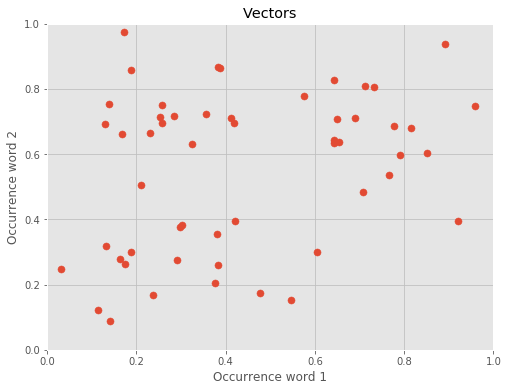

In [28]:
from sklearn.cluster import KMeans

seed = 2
np.random.seed(seed)  # to reproduce the data later on

num_clusters = 3


def plot_clustering(x, y, title, mx=None, ymax=None, xmin=None, km=None):
    plt.figure(num=None, figsize=(8, 6))
    if km:
        plt.scatter(x, y, s=50, c=km.predict(list(zip(x, y))))
    else:
        plt.scatter(x, y, s=50)

    plt.title(title)
    plt.xlabel("Occurrence word 1")
    plt.ylabel("Occurrence word 2")

    plt.autoscale(tight=True)
    plt.ylim(ymin=0, ymax=1)
    plt.xlim(xmin=0, xmax=1)
    plt.grid(True, linestyle='-', color='0.75')

    return plt


xw1 = scipy.stats.norm(loc=0.3, scale=.15).rvs(20)
yw1 = scipy.stats.norm(loc=0.3, scale=.15).rvs(20)

xw2 = scipy.stats.norm(loc=0.7, scale=.15).rvs(20)
yw2 = scipy.stats.norm(loc=0.7, scale=.15).rvs(20)

xw3 = scipy.stats.norm(loc=0.2, scale=.15).rvs(20)
yw3 = scipy.stats.norm(loc=0.8, scale=.15).rvs(20)

x = np.append(np.append(xw1, xw2), xw3)
y = np.append(np.append(yw1, yw2), yw3)

plot_clustering(x, y, "Vectors")
save_png("01_clustering_data")

### Clustering after 1st iteration

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 3.7464563797


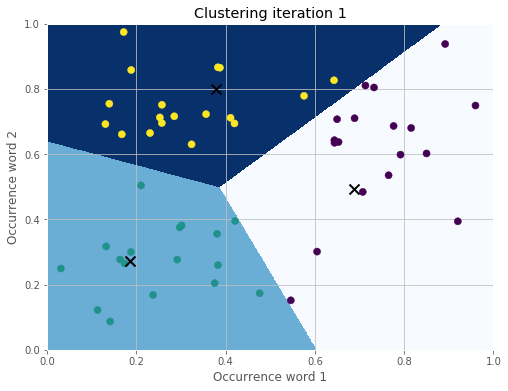

In [29]:
mx, my = np.meshgrid(np.arange(0, 1, 0.001), np.arange(0, 1, 0.001))

km = KMeans(init='random', n_clusters=num_clusters, verbose=1,
            n_init=1, max_iter=1,
            random_state=seed)
km.fit(np.array(list(zip(x, y))))

Z = km.predict(np.c_[mx.ravel(), my.ravel()]).reshape(mx.shape)

plot_clustering(x, y, "Clustering iteration 1", km=km)
plt.imshow(Z, interpolation='nearest',
           extent=(mx.min(), mx.max(), my.min(), my.max()),
           cmap=plt.cm.Blues,
           aspect='auto', origin='lower')

c1a, c1b, c1c = km.cluster_centers_
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
              marker='x', linewidth=2, s=100, color='black')
save_png("02_clustering_iteration_1")

### Clustering after 2nd iteration

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 3.7464563797
start iteration
done sorting
end inner loop
Iteration 1, inertia 2.83547634192


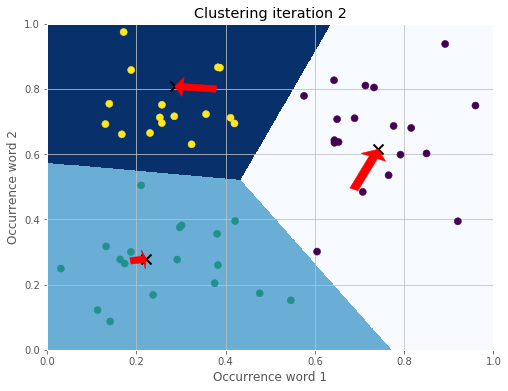

In [30]:
km = KMeans(init='random', n_clusters=num_clusters, verbose=1,
            n_init=1, max_iter=2,
            random_state=seed)
km.fit(np.array(list(zip(x, y))))

Z = km.predict(np.c_[mx.ravel(), my.ravel()]).reshape(mx.shape)

plot_clustering(x, y, "Clustering iteration 2", km=km)
plt.imshow(Z, interpolation='nearest',
           extent=(mx.min(), mx.max(), my.min(), my.max()),
           cmap=plt.cm.Blues,
           aspect='auto', origin='lower')

c2a, c2b, c2c = km.cluster_centers_
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
              marker='x', linewidth=2, s=100, color='black')

plt.gca().add_patch(plt.Arrow(c1a[0], c1a[1], c2a[0] - c1a[0], c2a[1] - c1a[1], width=0.1, color='red'))
plt.gca().add_patch(plt.Arrow(c1b[0], c1b[1], c2b[0] - c1b[0], c2b[1] - c1b[1], width=0.1, color='red'))
plt.gca().add_patch(plt.Arrow(c1c[0], c1c[1], c2c[0] - c1c[0], c2c[1] - c1c[1], width=0.1, color='red'))

save_png("03_clustering_iteration_2")

### Final clustering
We iterate at max 10 iterations, but will converge earlier.

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 3.7464563797
start iteration
done sorting
end inner loop
Iteration 1, inertia 2.83547634192
start iteration
done sorting
end inner loop
Iteration 2, inertia 2.53604625612
start iteration
done sorting
end inner loop
Iteration 3, inertia 2.44722301621
start iteration
done sorting
end inner loop
Iteration 4, inertia 2.44722301621
center shift 0.000000e+00 within tolerance 7.366762e-06


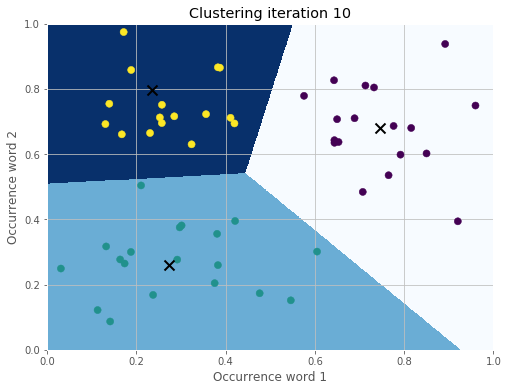

In [31]:
# 10 iterations ####################
km = KMeans(init='random', n_clusters=num_clusters, verbose=1,
            n_init=1, max_iter=10,
            random_state=seed)
km.fit(np.array(list(zip(x, y))))

Z = km.predict(np.c_[mx.ravel(), my.ravel()]).reshape(mx.shape)

plot_clustering(x, y, "Clustering iteration 10", km=km)
plt.imshow(Z, interpolation='nearest',
             extent=(mx.min(), mx.max(), my.min(), my.max()),
             cmap=plt.cm.Blues,
             aspect='auto', origin='lower')

plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
              marker='x', linewidth=2, s=100, color='black')
save_png("04_clustering_iteration_final")

## Testing our idea on real data

In [32]:
import sklearn.datasets
all_data = sklearn.datasets.fetch_20newsgroups(subset='all') 
print(len(all_data.filenames))
print(all_data.target_names)

18846
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [33]:
train_data = sklearn.datasets.fetch_20newsgroups(subset="train")
print(len(train_data.filenames))

test_data = sklearn.datasets.fetch_20newsgroups(subset='test')
print(len(test_data.filenames))

11314
7532


In [34]:
groups = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware',
          'comp.sys.mac.hardware', 'comp.windows.x', 'sci.space']

train_data = sklearn.datasets.fetch_20newsgroups(subset="train", categories=groups)
print(len(train_data.filenames))

test_data = sklearn.datasets.fetch_20newsgroups(subset='test', categories=groups)
print(len(test_data.filenames))

3529
2349


## Clustering posts

In [35]:
vectorizer = StemmedTfidfVectorizer(min_df=10, max_df=0.5,
                                    stop_words='english', decode_error='ignore')
vectorized = vectorizer.fit_transform(train_data.data)

num_samples, num_features = vectorized.shape
print("#samples: %d, #features: %d" % (num_samples, num_features))

#samples: 3529, #features: 4712


In [36]:
num_clusters = 50  # np.unique(labels).shape[0]

km = KMeans(n_clusters=num_clusters, n_init=1, verbose=1, random_state=3)
clustered = km.fit(vectorized)

Initialization complete
Iteration  0, inertia 5686.053
Iteration  1, inertia 3164.888
Iteration  2, inertia 3132.208
Iteration  3, inertia 3111.713
Iteration  4, inertia 3098.584
Iteration  5, inertia 3092.191
Iteration  6, inertia 3087.277
Iteration  7, inertia 3084.100
Iteration  8, inertia 3082.800
Iteration  9, inertia 3082.234
Iteration 10, inertia 3081.949
Iteration 11, inertia 3081.843
Iteration 12, inertia 3081.791
Iteration 13, inertia 3081.752
Iteration 14, inertia 3081.660
Iteration 15, inertia 3081.617
Iteration 16, inertia 3081.589
Iteration 17, inertia 3081.571
Converged at iteration 17: center shift 0.000000e+00 within tolerance 2.069005e-08


In [37]:
print("km.labels_=%s" % km.labels_)
print("km.labels_.shape=%s" % km.labels_.shape)

km.labels_=[48 23 31 ...,  6  2 22]
km.labels_.shape=3529


In [38]:
new_post = '''\
Disk drive problems. Hi, I have a problem with my hard disk.
After 1 year it is working only sporadically now.
I tried to format it, but now it doesn't boot any more.
Any ideas? Thanks.
'''

new_post_vec = vectorizer.transform([new_post])
new_post_label = km.predict(new_post_vec)[0]

similar_indices = (km.labels_ == new_post_label).nonzero()[0]

similar = []
for i in similar_indices:
    dist = scipy.linalg.norm((new_post_vec - vectorized[i]).toarray())
    similar.append((dist, train_data.data[i]))

In [39]:
similar = sorted(similar)
print("Count similar: %i" % len(similar))

show_at_1 = similar[0]
show_at_2 = similar[int(len(similar) / 10)]
show_at_3 = similar[int(len(similar) / 2)]

print("=== #1 ===")
print(show_at_1)
print()

print("=== #2 ===")
print(show_at_2)
print()

print("=== #3 ===")
print(show_at_3)

Count similar: 56
=== #1 ===
(1.0378441731334074, "From: Thomas Dachsel <GERTHD@mvs.sas.com>\nSubject: BOOT PROBLEM with IDE controller\nNntp-Posting-Host: sdcmvs.mvs.sas.com\nOrganization: SAS Institute Inc.\nLines: 25\n\nHi,\nI've got a Multi I/O card (IDE controller + serial/parallel\ninterface) and two floppy drives (5 1/4, 3 1/2) and a\nQuantum ProDrive 80AT connected to it.\nI was able to format the hard disk, but I could not boot from\nit. I can boot from drive A: (which disk drive does not matter)\nbut if I remove the disk from drive A and press the reset switch,\nthe LED of drive A: continues to glow, and the hard disk is\nnot accessed at all.\nI guess this must be a problem of either the Multi I/o card\nor floppy disk drive settings (jumper configuration?)\nDoes someone have any hint what could be the reason for it.\nPlease reply by email to GERTHD@MVS.SAS.COM\nThanks,\nThomas\n+-------------------------------------------------------------------+\n| Thomas Dachsel            

In [40]:
post_group = zip(train_data.data, train_data.target)

# Create a list of tuples that can be sorted by
# the length of the posts
all = [(len(post[0]), post[0], train_data.target_names[post[1]])
       for post in post_group]
graphics = sorted([post for post in all if post[2] == 'comp.graphics'])
print(graphics[5])

(245, 'From: SITUNAYA@IBM3090.BHAM.AC.UK\nSubject: test....(sorry)\nOrganization: The University of Birmingham, United Kingdom\nLines: 1\nNNTP-Posting-Host: ibm3090.bham.ac.uk\n\n==============================================================================\n', 'comp.graphics')


In [41]:
noise_post = graphics[5][1]

analyzer = vectorizer.build_analyzer()
print(list(analyzer(noise_post)))

['situnaya', 'ibm3090', 'bham', 'ac', 'uk', 'subject', 'test', 'sorri', 'organ', 'univers', 'birmingham', 'unit', 'kingdom', 'line', 'nntp', 'post', 'host', 'ibm3090', 'bham', 'ac', 'uk']


In [42]:
useful = set(analyzer(noise_post)).intersection(vectorizer.get_feature_names())
print(sorted(useful))
# ['ac', 'birmingham', 'host', 'kingdom', 'nntp', 'sorri', 'test', 'uk', 'unit', 'univers']

['ac', 'birmingham', 'host', 'kingdom', 'nntp', 'sorri', 'test', 'uk', 'unit', 'univers']


In [43]:
for term in sorted(useful):
    print('IDF(%-10s) = %.2f' % (term,
                            vectorizer._tfidf.idf_[vectorizer.vocabulary_[term]]))

IDF(ac        ) = 3.51
IDF(birmingham) = 6.77
IDF(host      ) = 1.74
IDF(kingdom   ) = 6.68
IDF(nntp      ) = 1.77
IDF(sorri     ) = 4.14
IDF(test      ) = 3.83
IDF(uk        ) = 3.70
IDF(unit      ) = 4.42
IDF(univers   ) = 1.91
